In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## PASCAL VOC data setup

In [2]:
# BASE_PATH = '/content/drive/MyDrive/ai/detection/detection-tutorial/'
BASE_PATH = '/content/drive/MyDrive/ai/detection/'

In [3]:
!ls {BASE_PATH}

detection-tutorial     faster_rcnn_model_0.pth	VOCtrainval_11-May-2012.tar
detectron2_test.ipynb  setup.ipynb


In [4]:
file = BASE_PATH + 'VOCtrainval_11-May-2012.tar'

In [5]:
%%time
!cp {file} .

CPU times: user 401 ms, sys: 81.3 ms, total: 483 ms
Wall time: 1min 12s


In [6]:
%%time
!tar -xvf ./VOCtrainval_11-May-2012.tar > /dev/null

CPU times: user 272 ms, sys: 52.5 ms, total: 324 ms
Wall time: 51.5 s


In [7]:
!pwd

/content


In [8]:
!ls

drive  sample_data  VOCdevkit  VOCtrainval_11-May-2012.tar


## Imports

In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

In [11]:
os.chdir("drive/My Drive/ai/detection/detection-tutorial")
# os.chdir("/content/")

In [12]:
# import sys
# sys.path.append('./dataset/')
# sys.path.append('./')
# sys.path

In [3]:
from transforms import get_transform
from utils import format_time, seed_everything
from utils import generate_anchors, process_anchors, find_jaccard_overlap
from utils_plot import show_predictions, show_image_and_bb, show_anchors, show_image_from_dataset

from loss import BoxLoss
from train import run_loader, get_device

from faster_rcnn import faster_rcnn

In [4]:
# !mkdir ./pascal-voc

In [5]:
# from dataset.pascal_voc_utils import create_data_lists
# create_data_lists(
#     voc07_path=None,
#     voc12_path='/content/VOCdevkit/VOC2012/',
#     # voc12_path='../VOCdevkit/VOC2012/',
#     output_folder='./pascal-voc/'
# )

In [6]:
SEED = 2021
seed_everything(SEED)

## PennFudanDataset

In [ ]:
from dataset.penn_fudan_dataset import PennFudanDataset

In [ ]:
# dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))
dataset = PennFudanDataset('../PennFudanPed', None)

In [ ]:
image, target = dataset[0]

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
target

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

tensor([159., 181., 301., 430.])
tensor([419., 170., 534., 485.])


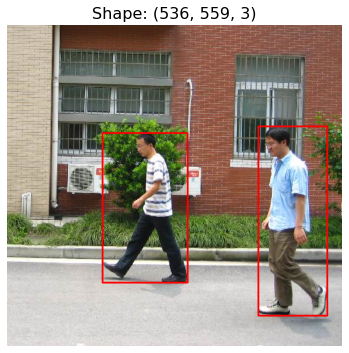

In [ ]:
# show_image(dataset, 0)
show_image_and_bb(image, target)

In [ ]:
anchors = generate_anchors()

In [ ]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [ ]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [ ]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [ ]:
def get_top_n_anchors(anchors, gt_boxes):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)
 
    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)
    
    prior_max_iou, prior_gt_box_idx = jaccard.max(1) # (N1), (N1)
    
    top_n = 10
    _, top_priors_idx = prior_max_iou.sort(descending=True)
    return anchors[top_priors_idx[:top_n]], prior_max_iou[top_priors_idx[:top_n]]

In [ ]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [ ]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [ ]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

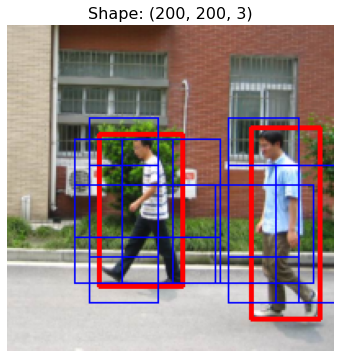

In [ ]:
show_anchors(image, target['boxes'], top_n_anchors)

## PASCAL VOC dataset

In [10]:
from dataset.pascal_voc_dataset import PascalVOCDataset
from utils import generate_anchors

In [11]:
# dataset = PascalVOCDataset('/content/pascal-voc/', 'TRAIN', get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/', 'TRAIN', get_transform(train=True))

In [41]:
anchors = generate_anchors()
anchors.shape

torch.Size([7731, 4])

GT:
tensor([107.6000,   0.0000, 150.8000, 107.0336])
tensor([22.4000,  0.0000, 65.2000, 91.1315])
Predictions:
tensor([ 10.0000,  10.0000, 190.0000, 190.0000])
tensor([-27.2792,  36.3604, 227.2792, 163.6396])
tensor([ 36.3604, -27.2792, 163.6396, 227.2792])
tensor([ 40.0000,  40.0000, 160.0000, 160.0000])
tensor([ 15.1472,  57.5736, 184.8528, 142.4264])
tensor([ 57.5736,  15.1472, 142.4264, 184.8528])
tensor([ 70.,  70., 130., 130.])
tensor([ 57.5736,  78.7868, 142.4264, 121.2132])
tensor([ 78.7868,  57.5736, 121.2132, 142.4264])
Shape: (200, 200, 3)


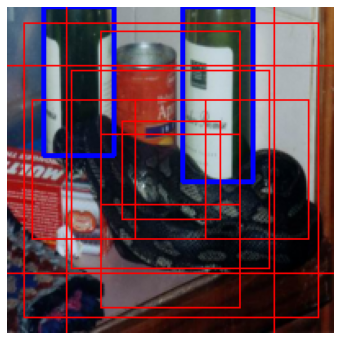

In [155]:
index = 5
image, target = dataset[index]

gt_boxes = target['boxes']

N = 9
start = 24
anchors_to_show = anchors[start*N:(start+1)*N]

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, anchors_to_show, verbose=True)

In [19]:
def get_top_n_anchors(anchors, gt_boxes, top_n=10):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)
 
    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)
    
    prior_max_iou, prior_gt_box_idx = jaccard.max(1) # (N1), (N1)
    
    _, top_priors_idx = prior_max_iou.sort(descending=True)
    return anchors[top_priors_idx[:top_n]], prior_max_iou[top_priors_idx[:top_n]]

In [49]:
def get_positive_anchors(anchors, gt_boxes, threshold = 0.5):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)
 
    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)
    
    prior_max_iou, prior_gt_box_idx = jaccard.max(1) # (N1), (N1)

    prior_labels = (prior_max_iou > threshold).int() # (N1)
    prior_boxes = gt_boxes[prior_gt_box_idx]

    positive_anchors = (prior_labels != 0)

    return anchors[positive_anchors], prior_max_iou[positive_anchors]

Positive anchors number: 20
tensor([0.3382, 0.4600, 0.5206, 0.3194, 0.8919, 0.3959, 0.3046, 0.5271, 0.3048,
        0.3032, 0.4103, 0.3048, 0.3211, 0.4602, 0.7707, 0.3211, 0.4602, 0.6674,
        0.3400, 0.3048])
GT:
tensor([107.6000,   0.0000, 150.8000, 107.0336])
tensor([22.4000,  0.0000, 65.2000, 91.1315])
Predictions:
tensor([ 12.8571, -15.7143,  72.8571,  44.2857])
tensor([ 21.6439, -28.1407,  64.0703,  56.7121])
tensor([12.8571, 12.8571, 72.8571, 72.8571])
tensor([ 0.4307, 21.6439, 85.2836, 64.0703])
tensor([21.6439,  0.4307, 64.0703, 85.2836])
tensor([ 12.8571,  41.4286,  72.8571, 101.4286])
tensor([ 0.4307, 50.2154, 85.2836, 92.6418])
tensor([ 21.6439,  29.0022,  64.0703, 113.8550])
tensor([ 40.0000, -17.1429, 160.0000, 102.8571])
tensor([ 98.5714, -15.7143, 158.5714,  44.2857])
tensor([107.3582, -28.1407, 149.7846,  56.7121])
tensor([ 68.5714, -17.1429, 188.5714, 102.8571])
tensor([ 86.1450, -41.9957, 170.9978, 127.7100])
tensor([ 98.5714,  12.8571, 158.5714,  72.8571])
tensor

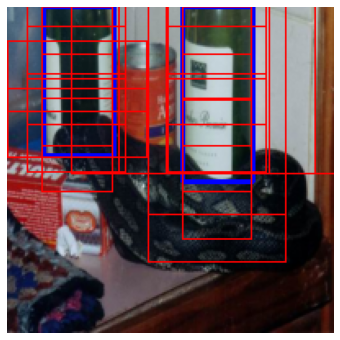

In [154]:
index = 5
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(clip=False)
top_n_anchors, top_n_iou = get_positive_anchors(anchors, gt_boxes, threshold = 0.3)
# top_n_anchors, top_n_iou = get_top_n_anchors(anchors, gt_boxes, top_n=10)

print(f'Positive anchors number: {top_n_anchors.shape[0]}')
print(top_n_iou)

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, top_n_anchors, verbose=True)

In [47]:
# index = 5
# show_image_from_dataset(dataset, index, top_n_anchors=10, verbose=True)

## Model single path

In [7]:
device = get_device()

No GPU available, using the CPU instead.


In [8]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [12]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [13]:
images, targets = next(iter(data_loader))
type(images), type(targets)

(tuple, tuple)

In [14]:
images = torch.stack(images, dim=0).to(device)
images.shape

torch.Size([8, 3, 200, 200])

In [15]:
# targets

In [32]:
net = faster_rcnn(device).to(device)

In [38]:
offsets, labels = net(images)
offsets.shape, labels.shape

(torch.Size([8, 7731, 4]), torch.Size([8, 7731, 1]))

In [42]:
criterion = BoxLoss(device)

In [43]:
loss = criterion(labels, offsets, targets)

In [44]:
loss

(tensor(2.1292, grad_fn=<AddBackward0>),
 tensor(1.4001, grad_fn=<SmoothL1LossBackward>),
 tensor(0.7291, grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [45]:
-np.log(1/2)

0.6931471805599453

In [46]:
gt_labels, gt_offsets = criterion.process_target_batch(targets)

In [47]:
gt_labels.shape

torch.Size([8, 7731])

In [48]:
torch.unique(torch.tensor([1,1,0,2]), return_counts=True)

(tensor([0, 1, 2]), tensor([1, 2, 1]))

## Train Model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
len(train_loader)

1443

In [ ]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}

model = faster_rcnn()

run_loader(model, train_loader, None, **params)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[train] index:  0, loss(box/cls) = 2.51103(1.77640/0.73463) time: 0:00:00


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index: 100, loss(box/cls) = 2.08980(1.67377/0.41603) time: 0:00:07
[train] index: 200, loss(box/cls) = 1.53724(1.12103/0.41621) time: 0:00:14
[train] index: 300, loss(box/cls) = 1.54284(1.17414/0.36871) time: 0:00:20
[train] index: 400, loss(box/cls) = 1.33409(0.94387/0.39022) time: 0:00:27
[train] index: 500, loss(box/cls) = 1.23265(0.95894/0.27371) time: 0:00:34
[train] index: 600, loss(box/cls) = 1.47188(1.15760/0.31429) time: 0:00:41
[train] index: 700, loss(box/cls) = 1.38084(1.11081/0.27003) time: 0:00:48
[train] index: 800, loss(box/cls) = 1.13748(0.78485/0.35264) time: 0:00:54
[train] index: 900, loss(box/cls) = 1.44728(1.20427/0.24301) time: 0:01:01
[train] index: 1000, loss(box/cls) = 1.23932(0.86597/0.37335) time: 0:01:08
[train] index: 1100, loss(box/cls) = 0.96726(0.75159/0.21567) time: 0:01:14
[train] index: 1200, loss(box/cls) = 1.32545(1.02724/0.29821) time: 0:01:21
[train] index: 1300, loss(box/cls) = 1.23931(0.93166/0.30765) time: 0:01:28
[train] index: 1400, 

{}

## Run

In [32]:
from train import main, run

In [41]:
from utils_plot import show_loss_history, show_loss_epochs_all, show_scores

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [35]:
# train_info = main(debug=True)

In [135]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'batch_size'    : 8,
    'num_epoch'     : 5,
    'verbose'       : True,
    'debug'         : False
}

seed_everything(SEED)
train_info, valid_loader, model = run(**params)

data size, all: 11540, train: 10386
data loader size, train: 1299, valid: 145, batch_size 8
learning_rate = 0.001
weight_decay = 0
num_epoch = 5

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
training started...
[train] epoch:  1, loss(box/cls) = 1.04659(0.70928/0.33731), time: 0:01:45
[valid] epoch:  1, loss(box/cls) = 0.88710(0.60495/0.28216), mAP = 0.19504,  time: 0:02:00
[train] epoch:  2, loss(box/cls) = 0.79315(0.52825/0.26489), time: 0:01:45
[valid] epoch:  2, loss(box/cls) = 0.79119(0.53126/0.25992), mAP = 0.22547,  time: 0:02:00
[train] epoch:  3, loss(box/cls) = 0.70851(0.46631/0.24220), time: 0:01:45
[valid] epoch:  3, loss(box/cls) = 0.75561(0.50806/0.24755), mAP = 0.26488,  time: 0:02:00
[train] epoch:  4, loss(box/cls) = 0.64607(0.42140/0.22467), time: 0:01:46
[valid] epoch:  4, loss(box/cls) = 0.72442(0.48446/0.23996), mAP = 0.27856,  time: 0:02:01
[train] epoch:  5, loss(box/cls) = 0.59158(0.38320/0.20838), time: 0:01:45
[valid] epoch:  5, loss(box/cls) = 

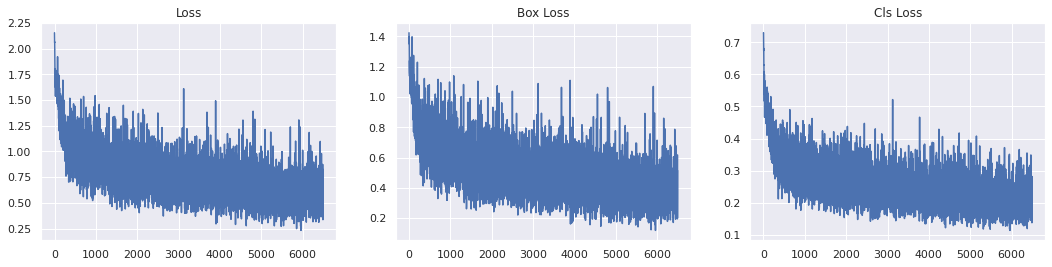

In [136]:
show_loss_history(train_info)

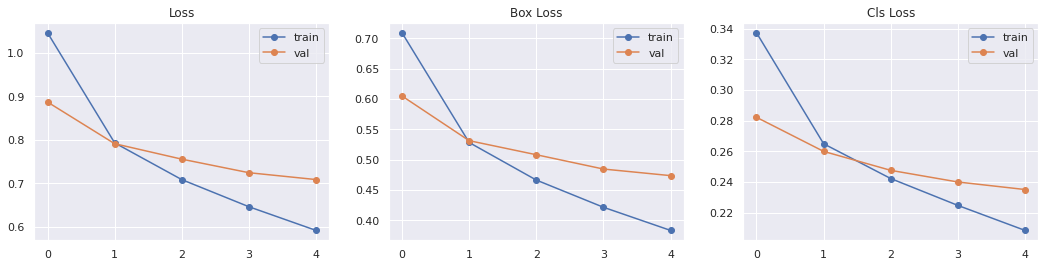

In [137]:
show_loss_epochs_all(train_info)

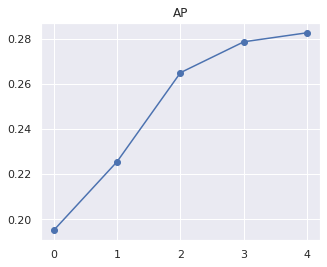

In [138]:
show_scores(train_info)

In [ ]:
model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
# torch.save(model.state_dict(), model_path)

## Show predictions

In [70]:
from utils_plot import show_predictions

In [67]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [71]:
len(valid_loader)

145

In [156]:
images, targets = next(iter(valid_loader))

In [157]:
images = torch.stack(images, dim=0).to(device)

In [158]:
# model = faster_rcnn(device)

# model_path = '../pth/faster_rcnn_model_0.pth'
# model.load_state_dict(torch.load(model_path, map_location='cpu'))

# model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
# model.load_state_dict(torch.load(model_path))

In [159]:
model.eval()
print('')

In [160]:
offsets, labels = model(images)

In [178]:
pred_boxes, pred_conf = model.detect(offsets, labels, prob_threshold=0.5, max_overlap=0.5)

GT:
tensor([ 84.0000, 101.8667,  90.4000, 130.6667])
tensor([ 63.6000, 175.4667,  73.2000, 199.4667])
tensor([ 92.4000, 171.2000, 158.8000, 199.4667])
tensor([135.6000, 131.7333, 182.4000, 198.9333])
tensor([ 22.8000, 105.0667,  50.4000, 187.7333])
tensor([ 63.6000, 114.6667, 130.4000, 199.4667])
tensor([109.2000,  87.4667, 168.0000, 199.4667])
tensor([127.2000,  82.1333, 172.4000, 154.1333])
tensor([ 78.4000,  63.4667, 114.4000, 173.3333])
tensor([ 35.2000,  69.8667,  79.2000, 189.3333])
tensor([  9.6000,  58.1333,  52.8000, 171.2000])
Predictions:
tensor([102.8559, 104.5223, 190.7548, 203.8687], grad_fn=<UnbindBackward>)
tensor([ 60.3256, 109.4992, 147.8954, 202.8630], grad_fn=<UnbindBackward>)
tensor([ 74.3110,  77.7911, 124.6704, 176.0041], grad_fn=<UnbindBackward>)
tensor([ 35.1517,  80.9831, 104.0607, 193.6601], grad_fn=<UnbindBackward>)
tensor([ 12.0298,  72.1200,  74.6218, 187.4594], grad_fn=<UnbindBackward>)
tensor([100.2176,  82.3688, 156.3048, 179.7894], grad_fn=<UnbindBackw

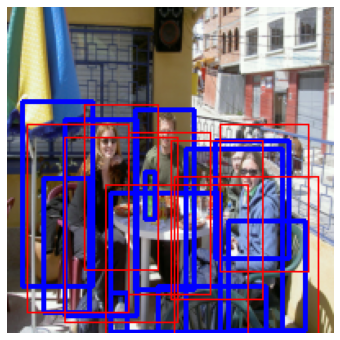

In [179]:
plt.figure(figsize=(6,6))
image_index = 0
gt_boxes = targets[image_index]['boxes']
final_boxes = pred_boxes[image_index].cpu()
show_predictions(images[image_index], gt_boxes, final_boxes, verbose=True)

## Evaluation

In [63]:
from utils import calculate_mAP

In [64]:
det_boxes = pred_boxes
det_scores = pred_conf
true_boxes = [t['boxes'] for t in targets]
true_labels = [t['labels'] for t in targets]

NameError: ignored

In [91]:
calculate_mAP(pred_boxes, pred_conf, true_boxes, true_labels, device)

tensor(0.3829, device='cuda:0')

In [65]:
from train import validate

In [68]:
criterion = BoxLoss(device)

In [111]:
loss_meters, mAP = validate(model, device, criterion, valid_loader)

[valid] index:  0, loss(box/cls) = 0.55522(0.36432/0.19090) time: 0:00:00
[valid] index: 100, loss(box/cls) = 0.52522(0.37740/0.14782) time: 0:00:08
[valid] calculate_mAP... time: 0:00:12
[valid] mAP = 0.24425,  time: 0:00:13


In [95]:
mAP

tensor(0.2871, device='cuda:0')

## ipywidgets

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
# dataset = PascalVOCDataset('./pascal-voc/', transforms=get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/')

get_transform_to_show


In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Image:',
    disabled=False
)

def handle_change(x):
    print(x)
    show_image_from_dataset(dataset, x, top_n_anchors=0)

In [ ]:
# do it only once

# import json
# # with open('./pascal-voc/label_map.json'), 'r') as j:
# data_folder = './pascal-voc'
# with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
#     labels = json.load(j)

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Image:', max=11540), Output()), _dom_classes=('widg…

<function __main__.handle_change(x)>

## Trainimg